<font color='black' size=6 face='Times New Roman'>Решение соревнования kaggle "Language Detection" by <b>Safronenkov R. S.</b></font>

<a href=https://www.kaggle.com/c/introml2020-3/overview>IntroML 2020. Language detection</a>

In [1]:
# !pip install pymorphy2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin
from sklearn.ensemble import RandomForestClassifier

import nltk
nltk.download('stopwords')
import pymorphy2
import zipfile
import gzip
import os
import re
import string
from tqdm import notebook
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def find_russian_words(text):
    '''
    Функция для удобства поиска любых слов, состоящих из букв русского алфавита
    '''
    return re.findall(r'[а-яё]', text.lower())

def clear_data_from_russian_letters(dataframe, language):
    '''
    Функция для поиска индексов объектов, в которых встречаются русские буквы, в заданном языке
    '''
    index_list = []
    indexes = train_df.sentence[train_df.language == language].index
    for i, text in enumerate(train_df.sentence[train_df.language == language]):
        if len(find_russian_words(text)) != 0:
            index_list.append(indexes[i])
    return index_list

def find_ukrainian(text):
    '''
    Функция для удобства поиска любых слов, состоящих из букв украинского алфавита
    '''
    return re.findall('[^\s]*і[^\s]*', text.lower())

def clear_data_from_uk_letters(dataframe, language):
    '''
    Функция для поиска индексов объектов, в которых встречаются украинские буквы, в заданном языке
    '''
    index_list = []
    indexes = train_df.sentence[train_df.language == language].index
    for i, text in enumerate(train_df.sentence[train_df.language == language]):
        if len(find_ukrainian(text)) != 0:
            index_list.append(indexes[i])
    return index_list

def delete_wrong_sentences(dataframe):
    '''
    Найти и удалить объекты русского языка и украинского в языках, в которых их быть не должно
    '''
    frame = dataframe.copy()
    for language in notebook.tqdm(['fr', 'en', 'th', 'ku', 'et']):
        index_list = clear_data_from_russian_letters(frame, language)
        frame = frame.drop(index_list, axis=0)
    index_list = clear_data_from_uk_letters(frame, 'ru')
    frame = frame.drop(index_list, axis=0)
    return frame

def tokenize(text):
    '''
    Токенизатор текста
    '''
#     return nltk.tokenize.word_tokenize(text.lower())
    return re.findall(r'[\w]+', text.lower())

def tokenize_corpus(corpus):
    '''
    Токенизировать корпус
    '''
    return [tokenize(text) for text in notebook.tqdm(corpus)]

def lemmatize(token):
    '''
    Лемматизация с использованием pymorphy2
    '''
    if lemmatizer.word_is_known(token):
        if token not in lemmatizer_cache:
            lemmatizer_cache[token] = lemmatizer.parse(token)[0].normal_form
        return lemmatizer_cache[token]
    return token

def join_tokenized_sentences(tokenized_sentences):
    '''
    Соединить токенизированный корпус обратно
    '''
    sentence_list = []
    for doc in notebook.tqdm(tokenized_sentences):
        sentence = str()
        for token in doc:
            sentence += token + ' '
        sentence_list.append(sentence.rstrip())
    return sentence_list

def preprocess_corpus(corpus, lemmatization=True):
    '''
    Токенизировать, лемматизировать (опционально), удалить лишнее, собрать обратно для корпуса
    '''
    print('Tokenizing...')
    tokenized_corpus = tokenize_corpus(corpus)
    if lemmatization:
        print('Lemmatizing...')
        lemmatized_docs = [[lemmatize(token) for token in text] for text in notebook.tqdm(tokenized_corpus)]

        cleared_docs = [[token for token in text if token not in stopwords_set] for text in lemmatized_docs]
        print('Joining...')
        joined = join_tokenized_sentences(cleared_docs)
    else:
        cleared_docs = [[token for token in text if token not in stopwords_set] for text in tokenized_corpus]
        print('Joining...')
        joined = join_tokenized_sentences(cleared_docs)
    return joined

def preprocess_df(df, **kwargs):
    '''
    Подготовка датафрейма
    '''
    frame = df.copy()
    corpus = frame.sentence.values
    joined = preprocess_corpus(corpus, **kwargs)
    frame['sentence'] = joined
    return frame

In [4]:
def find_words(text):
    '''
    Найти слова в тексте типа "&apos, &ty" и т.д.
    '''
    return re.findall(r'[\w]*&[\w]*', text.lower())

def find_all_words(corpus):
    '''
    Найти все слова в корпусе типа "&apos, &ty" и т.д.
    '''
    set_of_words = []
    for sentence in notebook.tqdm(corpus):
        list_of_words = find_words(sentence)
        set_of_words.extend(list_of_words)
    return set(set_of_words)

In [5]:
def count_mean_lenght(text):
    '''
    Посчитать среднюю длину слова в предложении
    '''
    lenght = 0
    count = 0
    for i in text.split(' '):
        if i not in string.punctuation:
            lenght += len(i)
            count += 1
    return round(lenght / (count + 1e-6), 3)

In [6]:
seed = 42

In [7]:
train_df = pd.read_csv('./data/train.csv.zip')
test_df = pd.read_csv('./data/test.csv.zip')

In [8]:
train_df.shape, test_df.shape

((3159633, 2), (2784634, 2))

In [9]:
train_df.head(15)

,sentence,language
0,"Pensez à la communication , le discours , les ...",fr
1,"Můžete si ji pronajmout , vzít na splátky , ko...",cs
2,"Každý starosta pochopil , že když mají tyto fo...",cs
3,"Det är ytterligare bevis , men ändå — Jag krit...",sv
4,كان الأمر لا يصدق .,ar
5,"Na primjer , pjesnik ga opisuje ovako .",hr
6,Semua rerumputan itu sekarang menutupi tanah s...,id
7,Det är en enorm utmaning för oss att göra det .,sv
8,Ono što ćete vidjeti - trebat ćete skočiti ovd...,hr
9,( Alqışlar ) Excel-dən istifadə etmişəm .,az


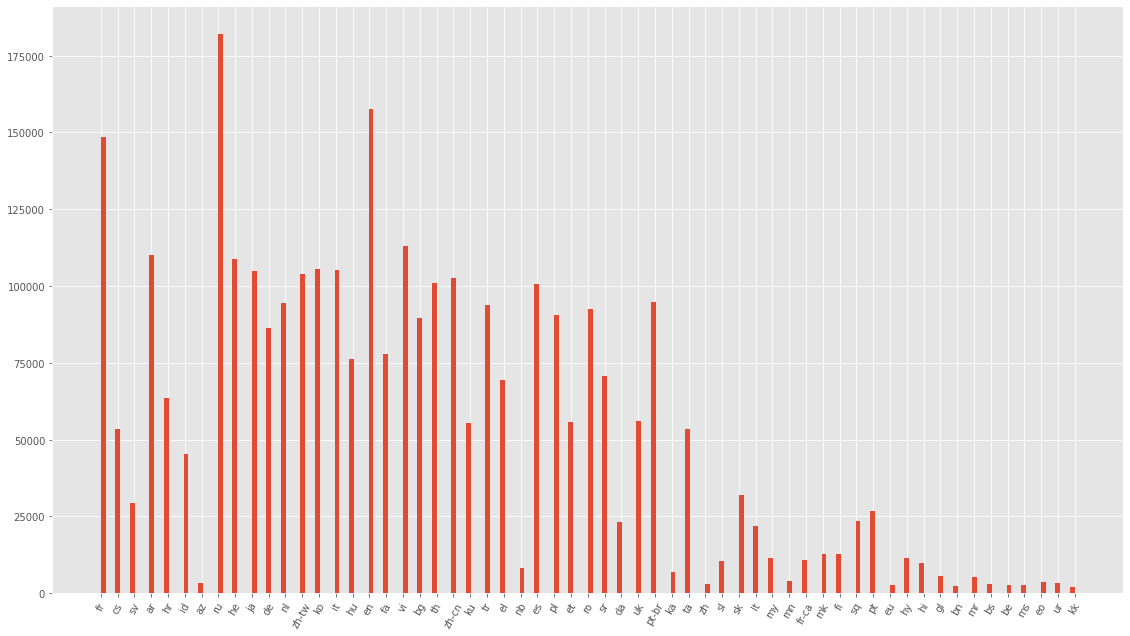

In [10]:
train_df.language.hist(bins=200, figsize=(19.20, 10.80), xrot=60)

In [11]:
train_df.isna().nunique() # нет NaN

sentence    1
language    1
dtype: int64

In [12]:
train_df.sentence[train_df.language == 'fr'].sample(5) # видно, что есть выбросы

856703     это что мы не как на вы они но из то он так дл...
3013714    Elle croit que &quot; &quot; C&apos; est comme...
586015     L&apos; autre question importante est : combie...
2142582    Mais étant donné ce dont je me sens capable dé...
2478970                              Vous pouvez me croire .
Name: sentence, dtype: object

In [13]:
lang_list = [] # посмотрим в каких языка встречаются слова русского языка
for language in notebook.tqdm(train_df.language.unique()):
    if len(clear_data_from_russian_letters(train_df, language)) != 0:
        lang_list.append(language)

In [14]:
lang_list # конечно, здесь есть языки в которых есть такие же буквы, как в русском алфавите, мы это учтем

['fr',
 'ru',
 'en',
 'bg',
 'th',
 'zh-cn',
 'ku',
 'es',
 'et',
 'sr',
 'uk',
 'lt',
 'mn',
 'mk',
 'be',
 'kk']

In [15]:
del(lang_list)

In [16]:
train_df = delete_wrong_sentences(train_df) # удаляем объекты, не подходящие по языку

In [17]:
train_df.sentence.sample(5)

1860700    แต ่ เมื ่ อผมอินกับเรื ่ องนี ้ เพิ ่ มขึ ้ น...
743303                        Ma cos&apos; è un ectocotilo ?
2993229      Κάθε ένας από εμάς έχει 23 ζεύγη χρωμοσωμάτων .
155683                                      だから私はこの問いには答えません
1270915    אבל תנו לי משהו כזה- ידידי מייק מארניין פיסל א...
Name: sentence, dtype: object

In [18]:
# train_df['mean_word_len'] = train_df.sentence.apply(lambda x:count_mean_lenght(x)) # это на деле не помогло

In [19]:
train_df.sample(5)

,sentence,language
954105,Můj dědeček byl také obr.,cs
149722,1993 年 ， 約有 一萬一千個家庭及警察 ， 在洛杉磯種族暴動後 ， 從洛杉磯逃到北愛達...,zh-tw
914443,"Saya jadi berpikir , kalau kita mulai bekerja ...",id
1993896,Medicamentele navighează prin tot corpul tău .,ro
628555,"Чому бути , того не минути .",uk


In [20]:
train_df.sentence[train_df.language == 'ru'].sample(5)

2231195    уровень холестерина в 140 единиц у мужчины воз...
319757                                   Наступило 17 июня .
182296     Проходя через этот скорбный период , я с удивл...
2144350                   Вы дали несколько подсказок , но …
1824536                 А поставить галочку требует усилий .
Name: sentence, dtype: object

In [21]:
train_df.shape

(2884631, 2)

<font color='black' size=5 face='Times New Roman'>Разобьем на тренировочный и валидационный датасеты</font>

In [22]:
train, test, y_tr, y_t = train_test_split(train_df.drop('language', axis=1),
                                          train_df['language'],
                                          test_size=0.2,
                                          random_state=seed)

In [23]:
train.shape, test.shape

((2307704, 1), (576927, 1))

In [24]:
train_df = train.join(y_tr)
val_df = test.join(y_t)

In [25]:
del(train, test, y_tr, y_t)

In [26]:
train_df.sample(5)

,sentence,language
272662,"На тази основа , ние го извадихме и казахме , ...",bg
1522325,Så nu finns det en al Qaida i islamiska Maghre...,sv
466388,E se você tiver expectativas corretas e admini...,pt-br
2689213,我们在一天早晨的拂晓之前离开了卡拉奇市 。,zh-cn
1808237,嫉妒让人身心俱疲,zh-cn


<font color='black' size=5 face='Times New Roman'>Найдем слова с символом &</font>

In [27]:
another_bad_words = find_all_words(train_df.sentence.values)

In [28]:
another = [] # и без & тоже учтем
for i in another_bad_words:
    if len(re.findall(r'&([\w]+)', i)) != 0:
        another.extend(re.findall(r'&([\w]+)', i))
another = set(another)

In [29]:
another_bad_words

{'&',
 '&amp',
 '&apos',
 '&gt',
 '&lt',
 '&quot',
 'a&apos',
 'ad&apos',
 'ain&apos',
 'aird&apos',
 'al&apos',
 'all&apos',
 'america&apos',
 'anch&apos',
 'attivita&apos',
 'aujourd&apos',
 'b&apos',
 'begl&apos',
 'bell&apos',
 'bil&apos',
 'bloomingdale&apos',
 'britain&apos',
 'bug&apos',
 'bunn&apos',
 'burt&apos',
 'c&apos',
 'can&apos',
 'cap&apos',
 'cent&apos',
 'center&apos',
 'ch&apos',
 'children&apos',
 'cinquan&apos',
 'cinquant&apos',
 'cio&apos',
 'citta&apos',
 'co&apos',
 'coase&apos',
 'com&apos',
 'cos&apos',
 'cosi&apos',
 'd&apos',
 'dal&apos',
 'dall&apos',
 'dawson&apos',
 'del&apos',
 'dell&apos',
 'delll&apos',
 'dem&apos',
 'dev&apos',
 'diciott&apos',
 'domino&apos',
 'don&apos',
 'dov&apos',
 'draeger&apos',
 'e&apos',
 'earle&apos',
 'entr&apos',
 'escalad&apos',
 'fin&apos',
 'fitch&apos',
 'french&apos',
 'gb&apos',
 'gbe&apos',
 'gl&apos',
 'gliel&apos',
 'google&apos',
 'grand&apos',
 'gulden&apos',
 'haigh&apos',
 'hell&apos',
 'hellman&apos',
 'her

In [30]:
another

{'amp', 'apos', 'gt', 'lt', 'quot'}

In [31]:
# stopwords = nltk.corpus.stopwords.words('russian') # добавление стопслов не улучшило модель
# stopwords.extend(nltk.corpus.stopwords.words('english'))
# stopwords.extend(nltk.corpus.stopwords.words('french'))
# stopwords.extend(nltk.corpus.stopwords.words('german'))
stopwords = []
stopwords.extend(another_bad_words)
stopwords.extend(another)
stopwords_set = set(stopwords)

<font color='black' size=5 face='Times New Roman'>Подготовим предложения к передаче в пайплайн с помощью функции <b>preprocess_df</b></font>

In [32]:
# lemmatizer = pymorphy2.MorphAnalyzer() # лемматизатор, опционально, без него даже лучше получилось
# lemmatizer_cache = {}

In [33]:
%%time
train_df = preprocess_df(train_df, lemmatization=False)
val_df = preprocess_df(val_df, lemmatization=False)
test_df = preprocess_df(test_df, lemmatization=False)

Tokenizing...



Joining...



Tokenizing...



Joining...



Tokenizing...



Joining...



CPU times: user 1min 32s, sys: 6.99 s, total: 1min 39s
Wall time: 1min 39s


In [35]:
# del(lemmatizer, lemmatizer_cache)

In [36]:
train_df.sample(5)

,sentence,language
1123888,و این ساختاری بسیار شکننده است,fa
2533468,the and of it that you to we this is in they s...,ta
1302520,e por fim eu acho que chega às crianças e no d...,pt-br
653033,mesmo à primeira vista os vossos olhos irão re...,pt
224942,и затоа продолжија,mk


<font color='black' size=5 face='Times New Roman'>Подготовка целевой переменной и передача в pipeline</font>

In [37]:
encoder = LabelEncoder()

In [38]:
encoder.fit(train_df["language"])

LabelEncoder()

In [39]:
y_train = encoder.transform(train_df["language"])
y_val = encoder.transform(val_df["language"])

In [40]:
class ColumnExtractor(TransformerMixin): # для того, чтобы сшивать фичи
    
    def __init__(self, column_name):
        self.column_name = column_name
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.column_name].values

In [41]:
# Нужно было для фичи со средней длиной предложения, не пригодилось
# class ColumnExtractor_with_reshape(TransformerMixin): # для того, чтобы сшивать фичи
    
#     def __init__(self, column_name):
#         self.column_name = column_name
    
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X, y=None):
#         return X[self.column_name].values.reshape(-1, 1)

In [42]:
model = SGDClassifier(random_state=seed,
                      loss='log',
                      class_weight='balanced',
                      alpha=0.0001,
                      n_jobs=-1, 
                      learning_rate='optimal')

In [43]:
pipeline = Pipeline([(
    'sentence', Pipeline([
        ('extractor', ColumnExtractor('sentence')),
        ('vectorizer', CountVectorizer(lowercase=False,
                                       ngram_range=(3, 3),
                                       stop_words=None,
                                       min_df=5,
                                       max_df=0.95,
                                       analyzer='char_wb',)
        )
    ])),
    ('clf', model)
])

In [44]:
# pipeline = Pipeline([
#     ('union', FeatureUnion([
#                    ('sentence', Pipeline([
#                                           ('extractor', ColumnExtractor('sentence')),
#                                           ('vectorizer', CountVectorizer(lowercase=False,
#                                        ngram_range=(3, 3),
#                                        stop_words=None,
#                                        min_df=5,
#                                        max_df=0.95,
#                                        analyzer='char_wb',))
#                    ])),
#                    ('mean_word_len', Pipeline([
#                                                ('extractor', ColumnExtractor_with_reshape('mean_word_len')),
#                                                ('scaler', StandardScaler())
#                    ]))
#     ])),
#     ('clf', model)
# ])

In [45]:
%%time

pipeline.fit(train_df, y_train)

CPU times: user 17min 33s, sys: 5.47 s, total: 17min 38s
Wall time: 10min 19s


Pipeline(memory=None,
         steps=[('sentence',
                 Pipeline(memory=None,
                          steps=[('extractor',
                                  <__main__.ColumnExtractor object at 0x7f1f1293c198>),
                                 ('vectorizer',
                                  CountVectorizer(analyzer='char_wb',
                                                  binary=False,
                                                  decode_error='strict',
                                                  dtype=<class 'numpy.int64'>,
                                                  encoding='utf-8',
                                                  input='content',
                                                  lowercase=False, max_df=0.95,
                                                  max_features=None, min_df=5,
                                                  ngram_range=(3, 3),
                                                  pr...
                 SGDC

In [46]:
print('Train score = {}, val score = {}'.format(balanced_accuracy_score(y_train, pipeline.predict(train_df)),
                                                balanced_accuracy_score(y_val, pipeline.predict(val_df))))

Train score = 0.9127320438198694, val score = 0.904138715169548


<font color='black' size=6 face='Times New Roman'>Submit результатов</font>

In [47]:
submit_predictions = pipeline.predict(test_df)

In [48]:
test_df['language'] = encoder.classes_[submit_predictions]

test_df.head()

,index,sentence,language
0,0,תודה לכם,he
1,1,precisamos de compaixão para começar e auto in...,pt-br
2,2,這個增長相當大 並且它將引發經濟的增長,zh-tw
3,3,시애틀에서 자란 제가 처음 가난을 보게 되던 때를 기억해요,ko
4,4,これをロボットに組み込みました,ja


In [49]:
test_df.sample(5)

,index,sentence,language
2558555,2558555,حول العالم هناك امرأة تموت كل دقيقة ونصف بسبب ...,ar
2219020,2219020,ولكن لم يذهب أحد بالفعل الى مكان حدود الحياة ك...,ar
100782,100782,а бомбовый прицел сообщит когда сбрасывать бомбу,ru
530729,530729,loại thức ăn ấy đấy đúng rồi,vi
2571142,2571142,but as more people showed up wanting water the...,en


In [50]:
test_df[['index',  'language']].to_csv('./submission.csv', index=False)

<font color='black' size=5 face='Times New Roman'>В итоге, лучшее что получал на валидации <b>0.904138715169548</b>, лемматизацию не делал, вышло хуже, лучше всего показал себя <b>CountVectorizer</b> и 3-граммы.</font>